In [41]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sns
from pathlib import Path
import requests
import json


In [42]:
alpha_api = 'GQ3V6KMM3ISFS1NB'

# global variables 
indexes = 'SPY QQQ IWM DIA'
sectors = 'IYC IYH IYK IYR IYZ XLB XLE XLF XLI XLK XLU'
index_plus_sectors = indexes + ' ' + sectors
optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

# dates
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()


In [43]:
# method for getting close prices on a list of stocks
# important - don't put unnecessary spaces in the tickers, especially if it's a single ticker
def get_close(start, end, tickers = 'spy', interval = '1d'):
    
    if len(tickers) < 5:
        df = yf.Ticker(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data.dropna(inplace= True)
        data = data.rename(tickers)
    else:
        df = yf.Tickers(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data.dropna(inplace= True)    
    return data

# method for getting cumulative return on a stock from a series of close prices
def get_cumprod(series):
    series = series.pct_change()
    series = (series + 1).cumprod()
    return series

# get correlation matrix from multiple series
def get_corr(stocks = []):
    all_stocks = pd.concat(stocks, axis=1).dropna()
    all_stocks = all_stocks.corr()
    return all_stocks

# method for getting er dates
def get_er_dates(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyEarnings'])
    #
    return df['reportedDate']

In [44]:
sectors = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = index_plus_sectors))
sectors_10 = get_cumprod(get_close(ten_years_ago, yesterday, tickers = index_plus_sectors))
sectors_5 = get_cumprod(get_close(five_years_ago, yesterday, tickers = index_plus_sectors))
sectors_3 = get_cumprod(get_close(three_years_ago, yesterday, tickers = index_plus_sectors))
sectors_1 = get_cumprod(get_close(one_year, yesterday, tickers = index_plus_sectors))
sectors_6_months = get_cumprod(get_close(six_months, yesterday, tickers = index_plus_sectors))

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


# Market Statistics Report

## Returns

In [45]:
sectors.hvplot().opts(height = 400,
                     width = 1000)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [46]:
sectors_corr_30 = sectors.corr()
sectors_corr_10 = sectors_10.corr()
sectors_corr_5 = sectors_5.corr()
sectors_corr_3 = sectors_3.corr()
sectors_corr_1 = sectors_1.corr()
sectors_corr_6_months = sectors_6_months.corr()

<AxesSubplot:>

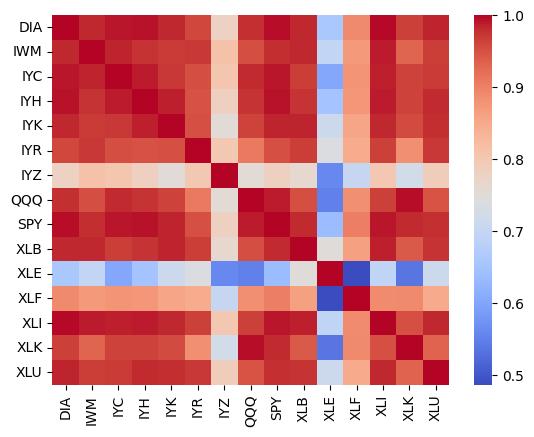

In [47]:
sns.heatmap(sectors_corr_30, cmap = 'coolwarm')

<AxesSubplot:>

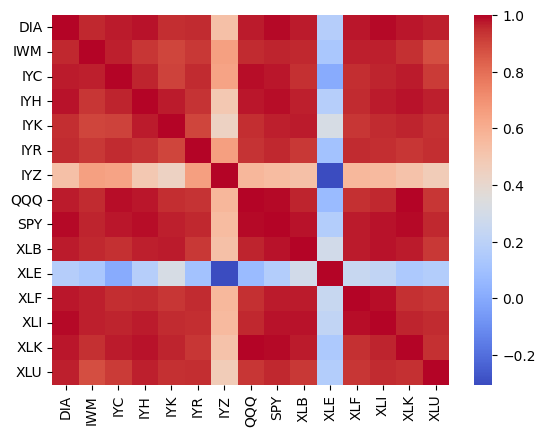

In [48]:
sns.heatmap(sectors_corr_10, cmap = 'coolwarm')

<AxesSubplot:>

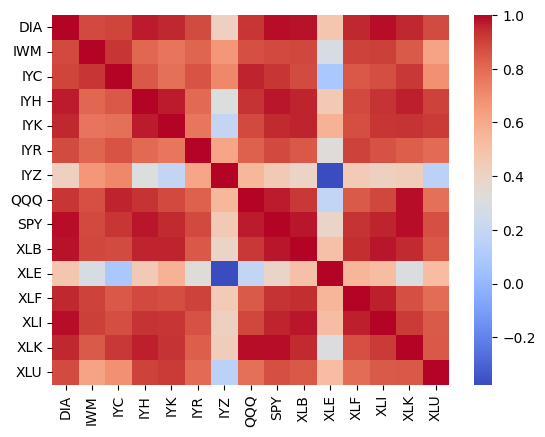

In [49]:
sns.heatmap(sectors_corr_5, cmap = 'coolwarm')

<AxesSubplot:>

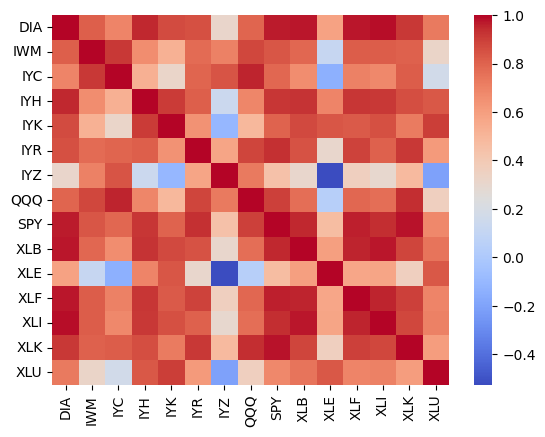

In [50]:
sns.heatmap(sectors_corr_3, cmap = 'coolwarm')

<AxesSubplot:>

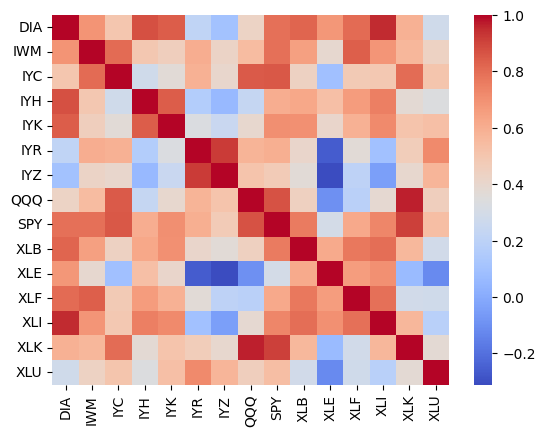

In [51]:
sns.heatmap(sectors_corr_1, cmap = 'coolwarm')

<AxesSubplot:>

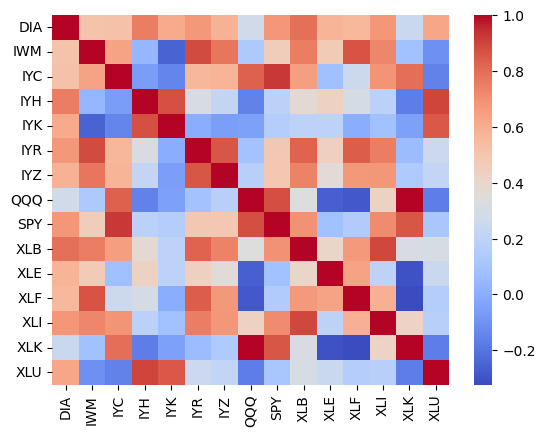

In [52]:
sns.heatmap(sectors_corr_6_months, cmap = 'coolwarm')

In [53]:
spy_monthly = get_close(thirty_years_ago, yesterday, interval= '1wk')
spy_8ema = spy_monthly.ewm(halflife=8).mean()
#spy_21ema = spy_monthly.ewm(halflife=21).mean()
#spy_50ema = spy_monthly.ewm(halflife=50).mean()
#spy_100ema = spy_monthly.ewm(halflife=100).mean()

In [54]:
spy_monthly.hvplot() * spy_8ema.hvplot(label = '8') #* spy_21ema.hvplot(label = '21') * spy_50ema.hvplot(label = '50') * spy_100ema.hvplot(label = '100') 

:Overlay
   .Curve.Spy :Curve   [Date]   (spy)
   .Curve.A_8 :Curve   [Date]   (spy)

In [55]:
bear_mask = spy_monthly < spy_8ema
bull_mask = spy_monthly > spy_8ema
bear = spy_monthly[bear_mask].hvplot.scatter()
bull = spy_monthly[bull_mask].hvplot.scatter()

bear * bull

:Overlay
   .Scatter.Spy.I  :Scatter   [Date]   (spy)
   .Scatter.Spy.II :Scatter   [Date]   (spy)

# 

In [ ]:

# now we need to take the dates one by one and find +/- 10 days and save that range as a variable then get stock return data for those dates and plot that curve
# date_range = pd.date_range(start = tsla_dates[0], end = tsla_dates[0] + pd.Timedelta(days = 20))


In [64]:
tsla = get_cumprod(get_close(six_months, yesterday, tickers = 'tsla'))
tsla_dates = get_er_dates('tsla', alpha_api)
tsla_dates

0     2023-04-19
1     2023-01-25
2     2022-10-19
3     2022-07-20
4     2022-04-20
5     2022-01-26
6     2021-10-20
7     2021-07-26
8     2021-04-26
9     2021-01-27
10    2020-10-21
11    2020-07-22
12    2020-04-29
13    2020-01-29
14    2019-10-23
15    2019-07-24
16    2019-04-24
17    2019-01-30
18    2018-10-24
19    2018-08-01
20    2018-05-02
21    2018-02-07
22    2017-11-01
23    2017-08-02
24    2017-05-03
25    2017-02-22
26    2016-10-26
27    2016-08-03
28    2016-05-04
29    2016-02-10
30    2015-11-03
31    2015-08-05
32    2015-05-06
33    2015-02-11
34    2014-11-05
35    2014-07-31
36    2014-05-07
37    2014-02-19
38    2013-11-05
39    2013-08-07
40    2013-05-08
41    2013-02-20
42    2012-11-05
43    2012-07-25
44    2012-05-09
45    2012-02-15
46    2011-11-02
47    2011-08-03
48    2011-05-04
49    2011-02-15
50    2010-11-09
51    2010-08-05
Name: reportedDate, dtype: object